<a href="https://colab.research.google.com/github/tymurs1/Stanford_CNN_2023/blob/assignment1/assignment1/two_layer_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Code/ML/cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Code/ML/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/Code/ML/cs231n/assignments/assignment1


# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

ModuleNotFoundError: ignored

In [ ]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: forward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [ ]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [ ]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [ ]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [ ]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1:

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
Sigmoid activation function have this problem. If we initialize W with the values in the range [-1;1] then we might get vanishing gradient problem. Maximum of the derivative of sigmoid is 0.25. Therefore max of absolute value of w*d(sigmoid) equals to 0.25. The more hidden layers are added the lower are the value of the gradients during backpropagation. See http://neuralnetworksanddeeplearning.com/chap5.html

# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [ ]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
Now implement the loss and gradient for softmax and SVM in the `softmax_loss` and `svm_loss` function in `cs231n/layers.py`. These should be similar to what you implemented in `cs231n/classifiers/softmax.py` and `cs231n/classifiers/linear_svm.py`.

You can make sure that the implementations are correct by running the following:

In [ ]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# # Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.483503037636722e-09


# Two-layer network
Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [ ]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.31e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves about `36%` accuracy on the validation set.

In [ ]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solver = Solver(model,
                data,
                optim_config={
                      'learning_rate': 2e-5,
                    },
                print_every=100)
solver.train()


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.304891
(Epoch 0 / 10) train acc: 0.066000; val_acc: 0.061000
(Iteration 101 / 4900) loss: 2.300464
(Iteration 201 / 4900) loss: 2.294215
(Iteration 301 / 4900) loss: 2.290476
(Iteration 401 / 4900) loss: 2.277087
(Epoch 1 / 10) train acc: 0.250000; val_acc: 0.235000
(Iteration 501 / 4900) loss: 2.261918
(Iteration 601 / 4900) loss: 2.264521
(Iteration 701 / 4900) loss: 2.248651
(Iteration 801 / 4900) loss: 2.255772
(Iteration 901 / 4900) loss: 2.164599
(Epoch 2 / 10) train acc: 0.226000; val_acc: 0.251000
(Iteration 1001 / 4900) loss: 2.174480
(Iteration 1101 / 4900) loss: 2.143498
(Iteration 1201 / 4900) loss: 2.172185
(Iteration 1301 / 4900) loss: 2.052689
(Iteration 1401 / 4900) loss: 2.106476
(Epoch 3 / 10) train acc: 0.258000; val_acc: 0.260000
(Iteration 1501 / 4900) loss: 2.099073
(Iteration 1601 / 4900) loss: 2.030199
(Iteration 1701 / 4900) loss: 2.009280
(Iteration 1801 / 4900) loss: 1.917630
(Iteration 1901 / 4900) loss: 2.038834
(Epoch 4 / 10) t

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.36 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

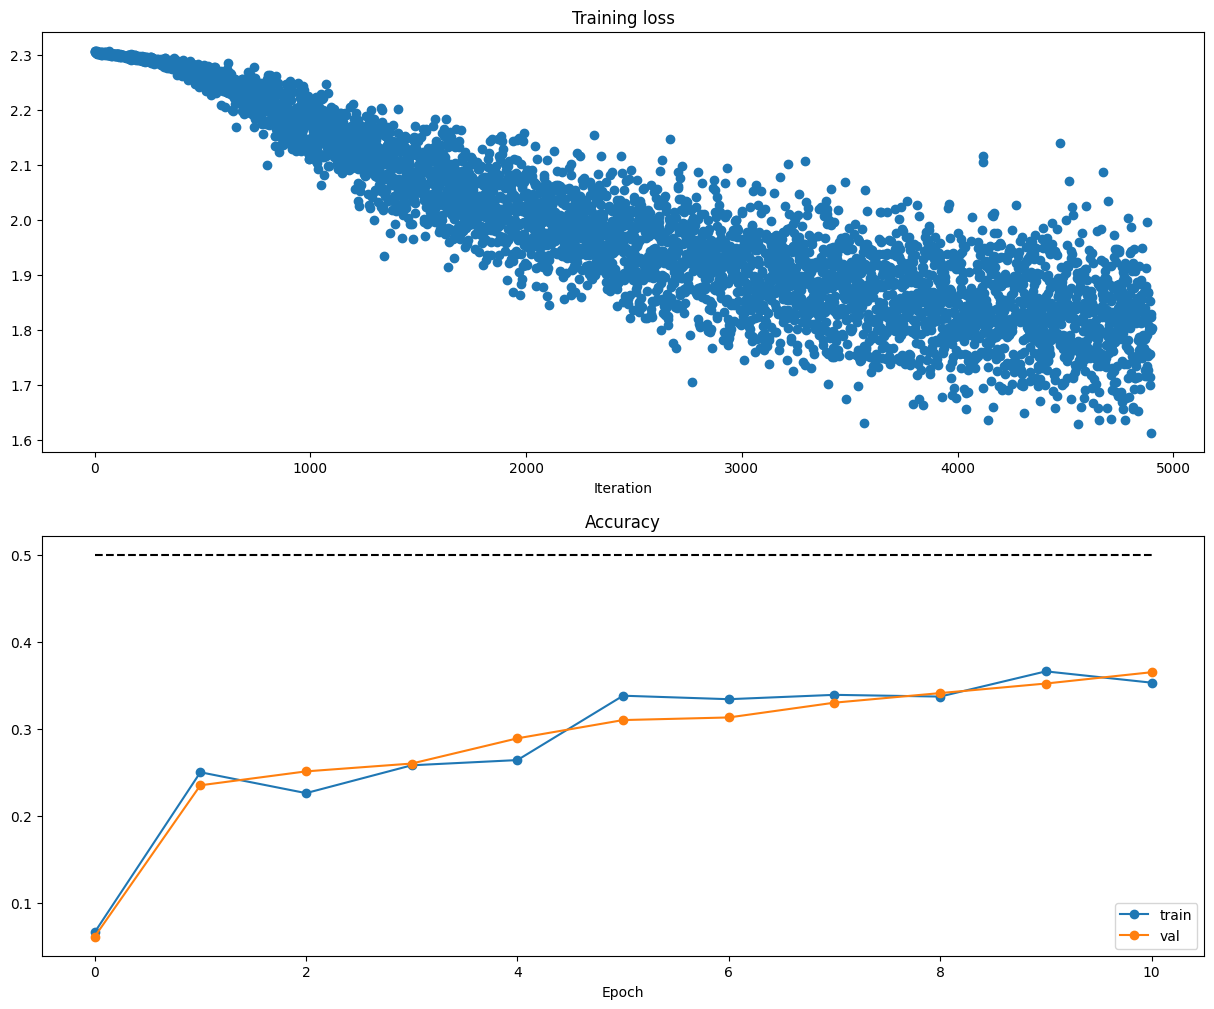

In [ ]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

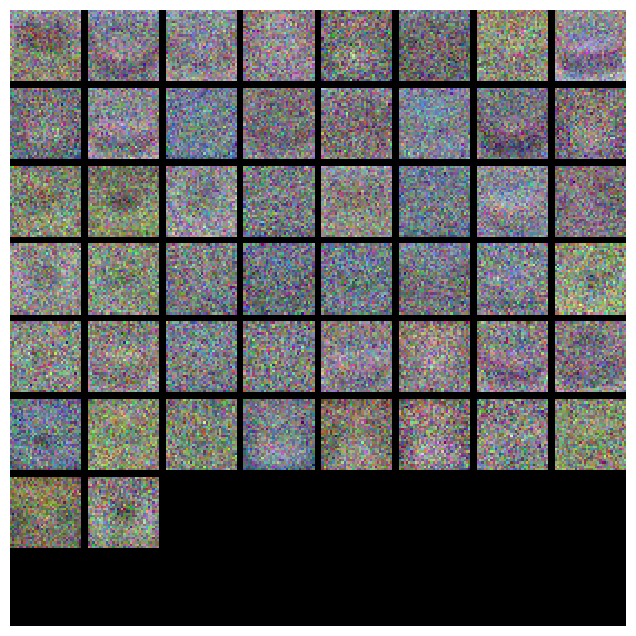

In [ ]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')

show_net_weights(model)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [ ]:
best_model = None


#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#1
learning_rates = [1e-4, 2e-4, 5e-4, 1e-3]
solvers = dict()
for lr in learning_rates:
  print('Learning Rate: ' + str(lr))
  model = TwoLayerNet(input_size, hidden_size, num_classes)
  solvers[lr] = Solver(model,
                data,
                optim_config={
                      'learning_rate': lr,
                    },
                print_every=200)
  solvers[lr].train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [ ]:
for lr, solver in solvers.items():
  print(lr, solver.val_acc_history[-1])

0.0001 0.467
0.0002 0.507
0.0005 0.505
0.001 0.473


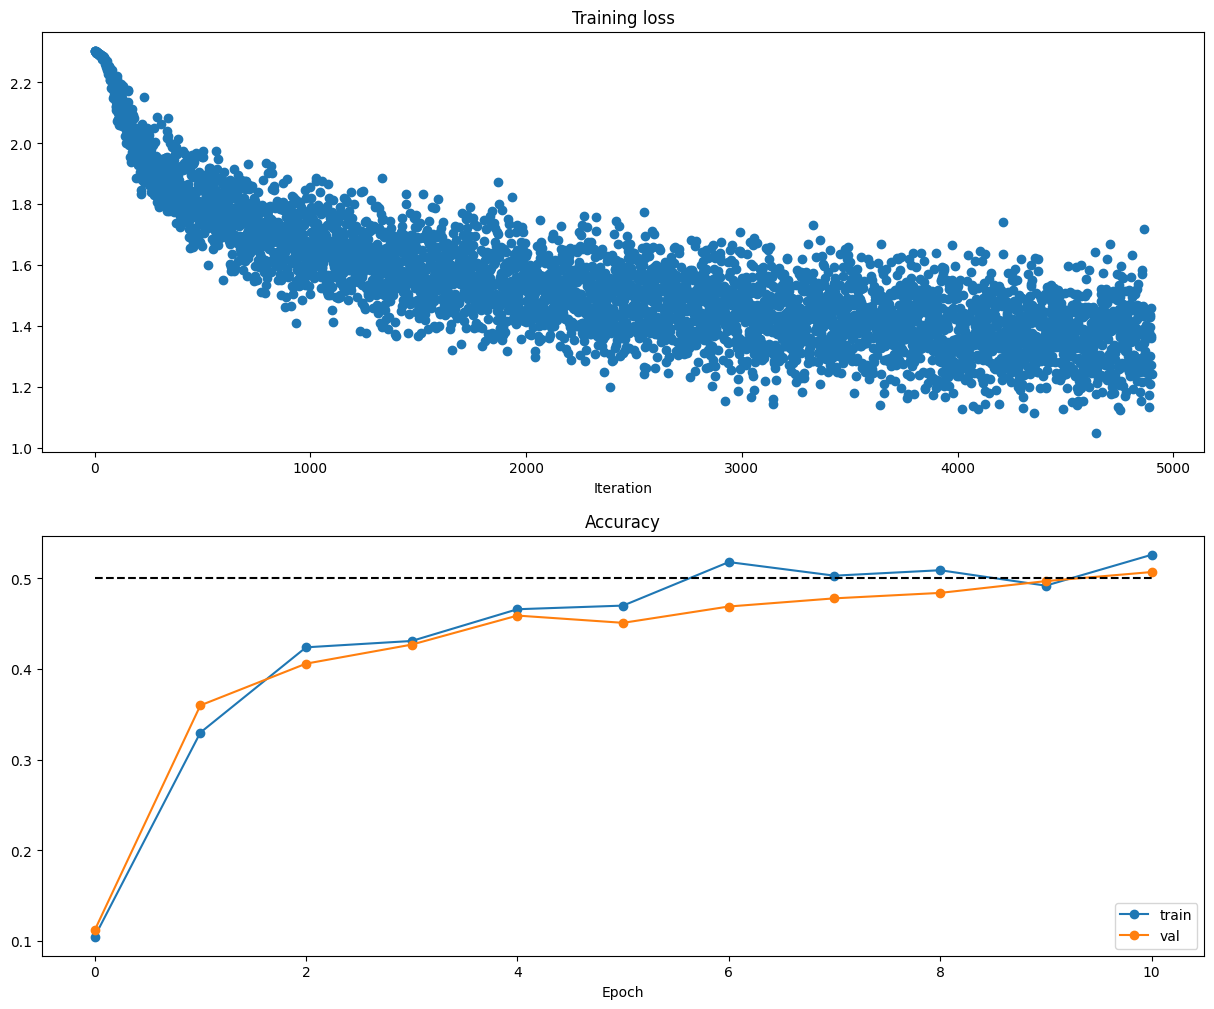

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solvers[2e-4].loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solvers[2e-4].train_acc_history, '-o', label='train')
plt.plot(solvers[2e-4].val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solvers[2e-4].val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

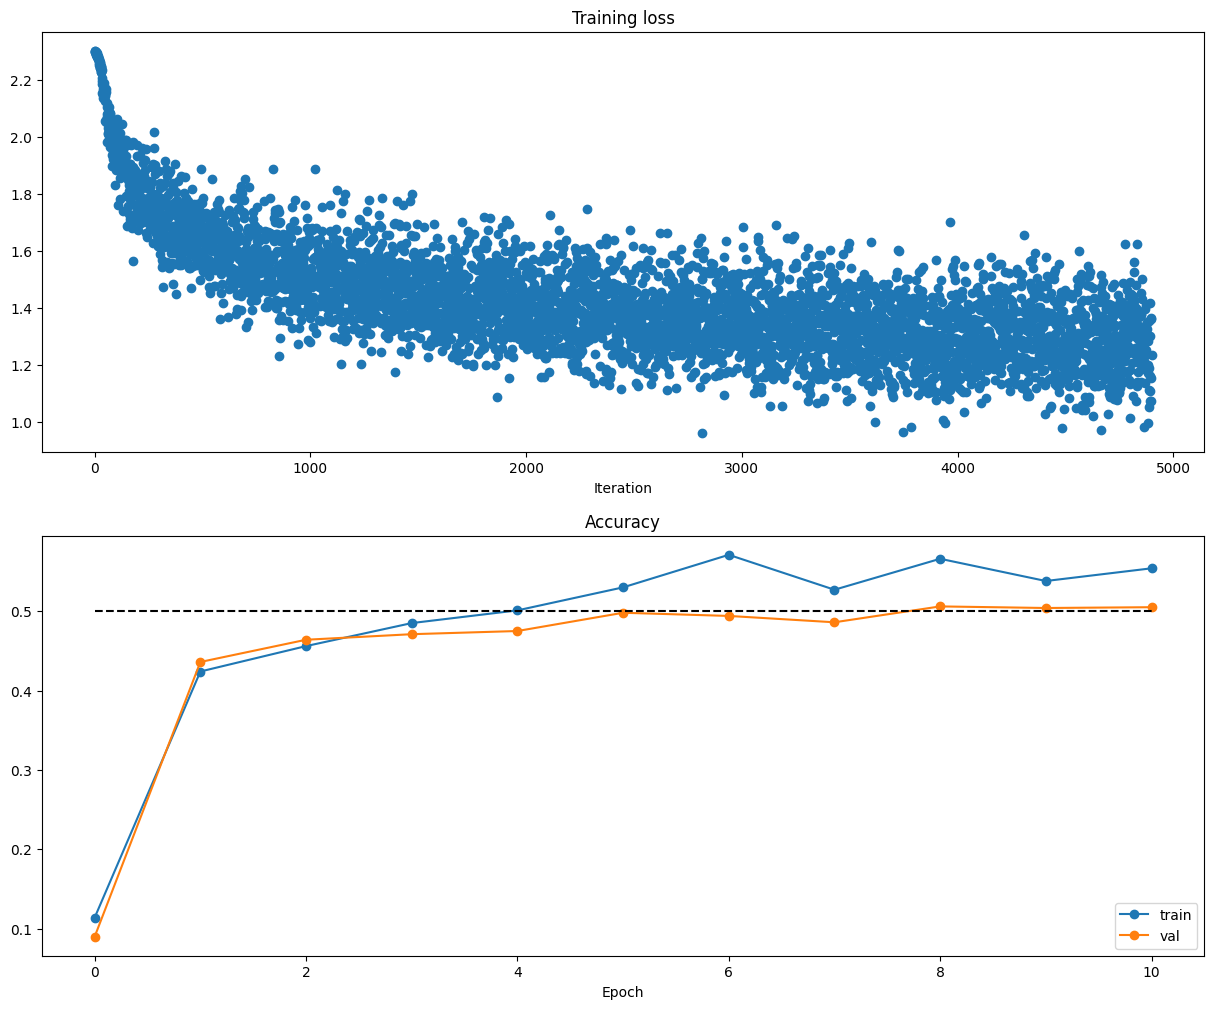

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solvers[5e-4].loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solvers[5e-4].train_acc_history, '-o', label='train')
plt.plot(solvers[5e-4].val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solvers[5e-4].val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [ ]:
LR = 5e-4
regularizations = [0.1, 0.3, 0.5, 0.7]
solvers_reg = dict()
for reg in regularizations:
  print('regularization: ' + str(reg))
  model_reg = TwoLayerNet(input_size, hidden_size, num_classes, reg=reg)
  solvers_reg[reg] = Solver(model_reg,
                data,
                optim_config={
                      'learning_rate': LR,
                    },
                print_every=200)
  solvers_reg[reg].train()


regularization: 0.1
(Iteration 1 / 4900) loss: 2.308738
(Epoch 0 / 10) train acc: 0.129000; val_acc: 0.133000
(Iteration 201 / 4900) loss: 1.956078
(Iteration 401 / 4900) loss: 1.589673
(Epoch 1 / 10) train acc: 0.435000; val_acc: 0.423000
(Iteration 601 / 4900) loss: 1.489038
(Iteration 801 / 4900) loss: 1.522463
(Epoch 2 / 10) train acc: 0.462000; val_acc: 0.456000
(Iteration 1001 / 4900) loss: 1.688009
(Iteration 1201 / 4900) loss: 1.502071
(Iteration 1401 / 4900) loss: 1.496454
(Epoch 3 / 10) train acc: 0.453000; val_acc: 0.456000
(Iteration 1601 / 4900) loss: 1.518185
(Iteration 1801 / 4900) loss: 1.224589
(Epoch 4 / 10) train acc: 0.469000; val_acc: 0.468000
(Iteration 2001 / 4900) loss: 1.337070
(Iteration 2201 / 4900) loss: 1.316214
(Iteration 2401 / 4900) loss: 1.333029
(Epoch 5 / 10) train acc: 0.560000; val_acc: 0.478000
(Iteration 2601 / 4900) loss: 1.536033
(Iteration 2801 / 4900) loss: 1.296321
(Epoch 6 / 10) train acc: 0.511000; val_acc: 0.503000
(Iteration 3001 / 4900) 

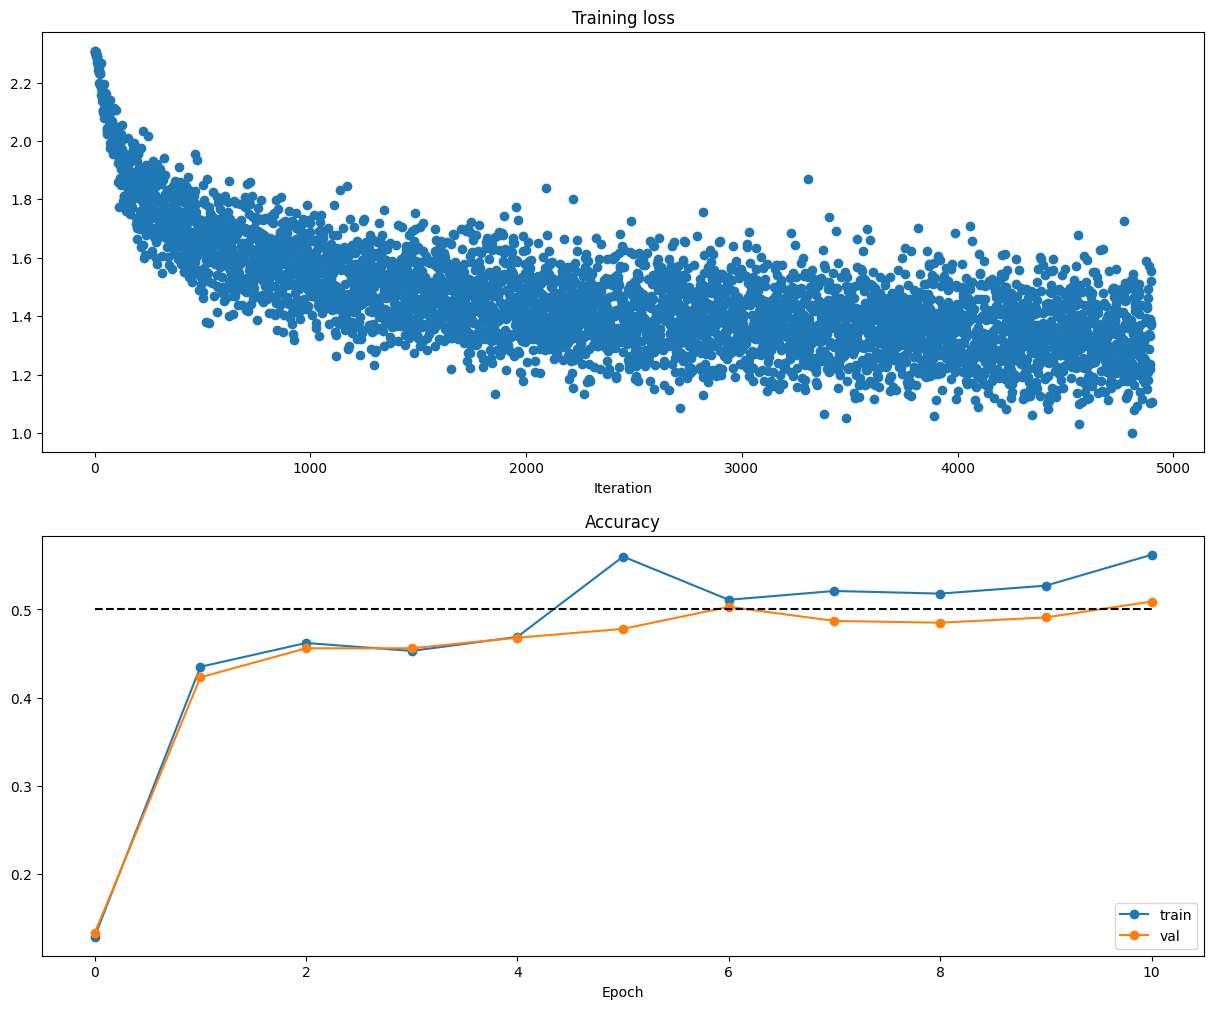

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solvers_reg[0.1].loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solvers_reg[0.1].train_acc_history, '-o', label='train')
plt.plot(solvers_reg[0.1].val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solvers_reg[0.1].val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

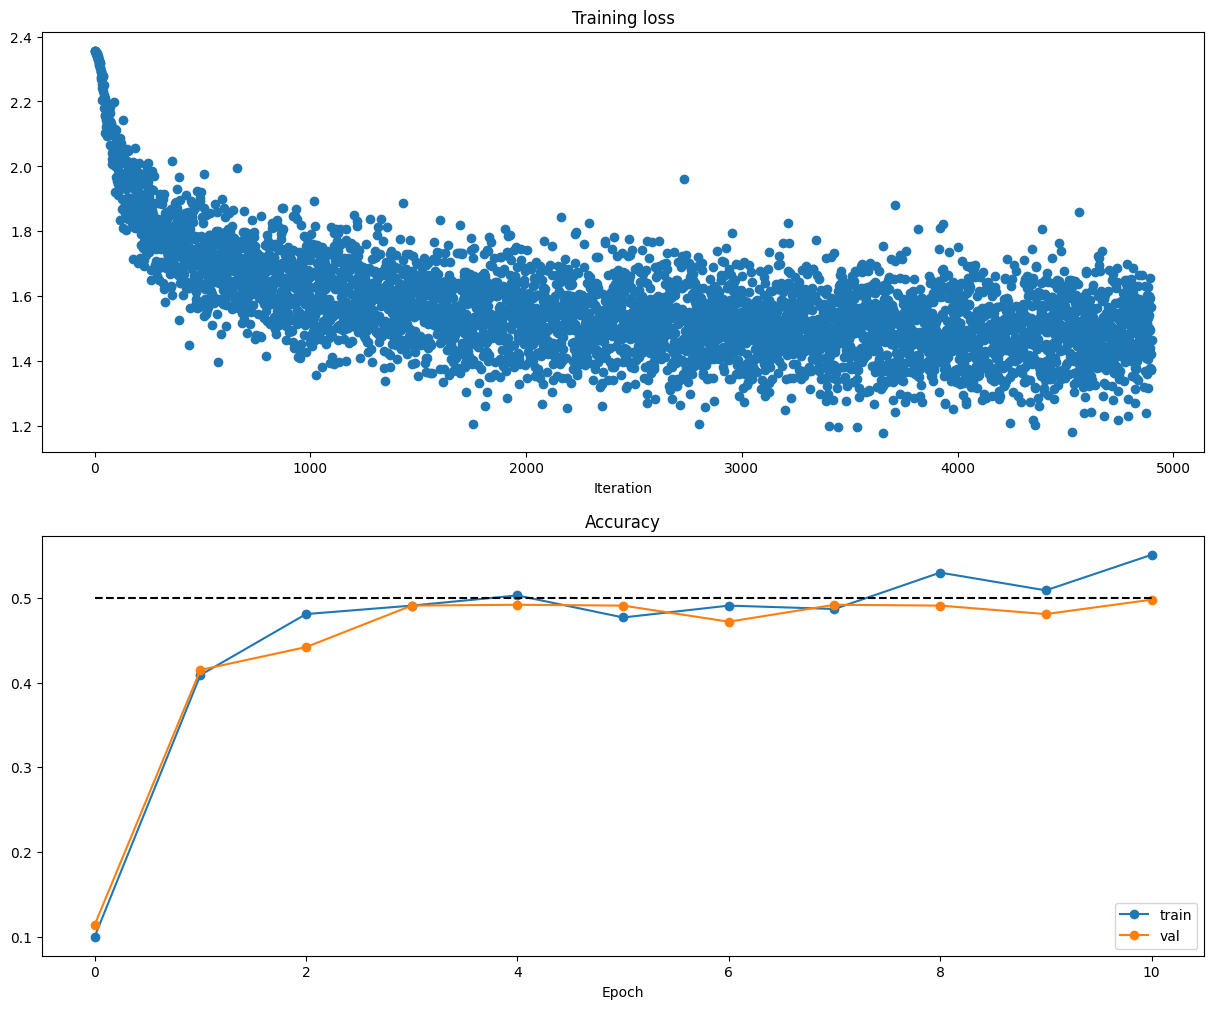

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solvers_reg[0.7].loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solvers_reg[0.7].train_acc_history, '-o', label='train')
plt.plot(solvers_reg[0.7].val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solvers_reg[0.7].val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

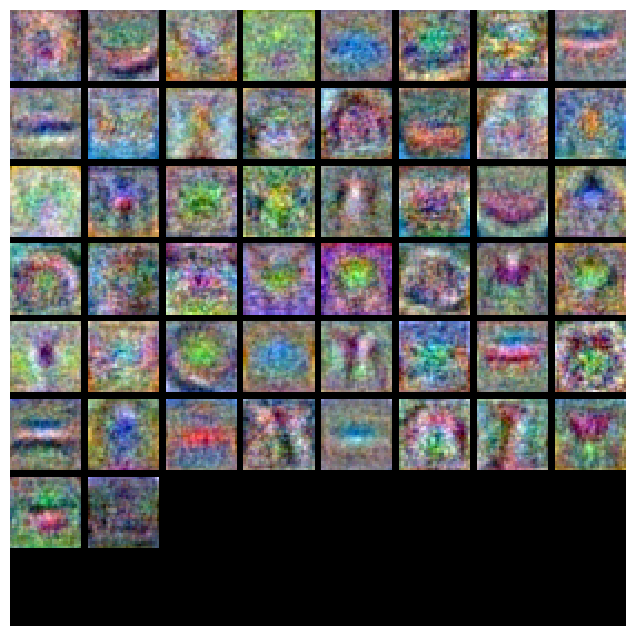

In [ ]:
show_net_weights(solvers_reg[0.7].model)

In [ ]:
solvers_reg[0.7].train()

(Iteration 1 / 4900) loss: 1.384994
(Epoch 110 / 10) train acc: 0.568000; val_acc: 0.504000
(Iteration 201 / 4900) loss: 1.343645
(Iteration 401 / 4900) loss: 1.523956
(Epoch 111 / 10) train acc: 0.565000; val_acc: 0.509000
(Iteration 601 / 4900) loss: 1.310733
(Iteration 801 / 4900) loss: 1.313823
(Epoch 112 / 10) train acc: 0.541000; val_acc: 0.511000
(Iteration 1001 / 4900) loss: 1.293116
(Iteration 1201 / 4900) loss: 1.333684
(Iteration 1401 / 4900) loss: 1.387000
(Epoch 113 / 10) train acc: 0.564000; val_acc: 0.500000
(Iteration 1601 / 4900) loss: 1.492927
(Iteration 1801 / 4900) loss: 1.376874
(Epoch 114 / 10) train acc: 0.547000; val_acc: 0.507000
(Iteration 2001 / 4900) loss: 1.696570
(Iteration 2201 / 4900) loss: 1.565921
(Iteration 2401 / 4900) loss: 1.593756
(Epoch 115 / 10) train acc: 0.542000; val_acc: 0.510000
(Iteration 2601 / 4900) loss: 1.575350
(Iteration 2801 / 4900) loss: 1.449797
(Epoch 116 / 10) train acc: 0.555000; val_acc: 0.529000
(Iteration 3001 / 4900) loss: 

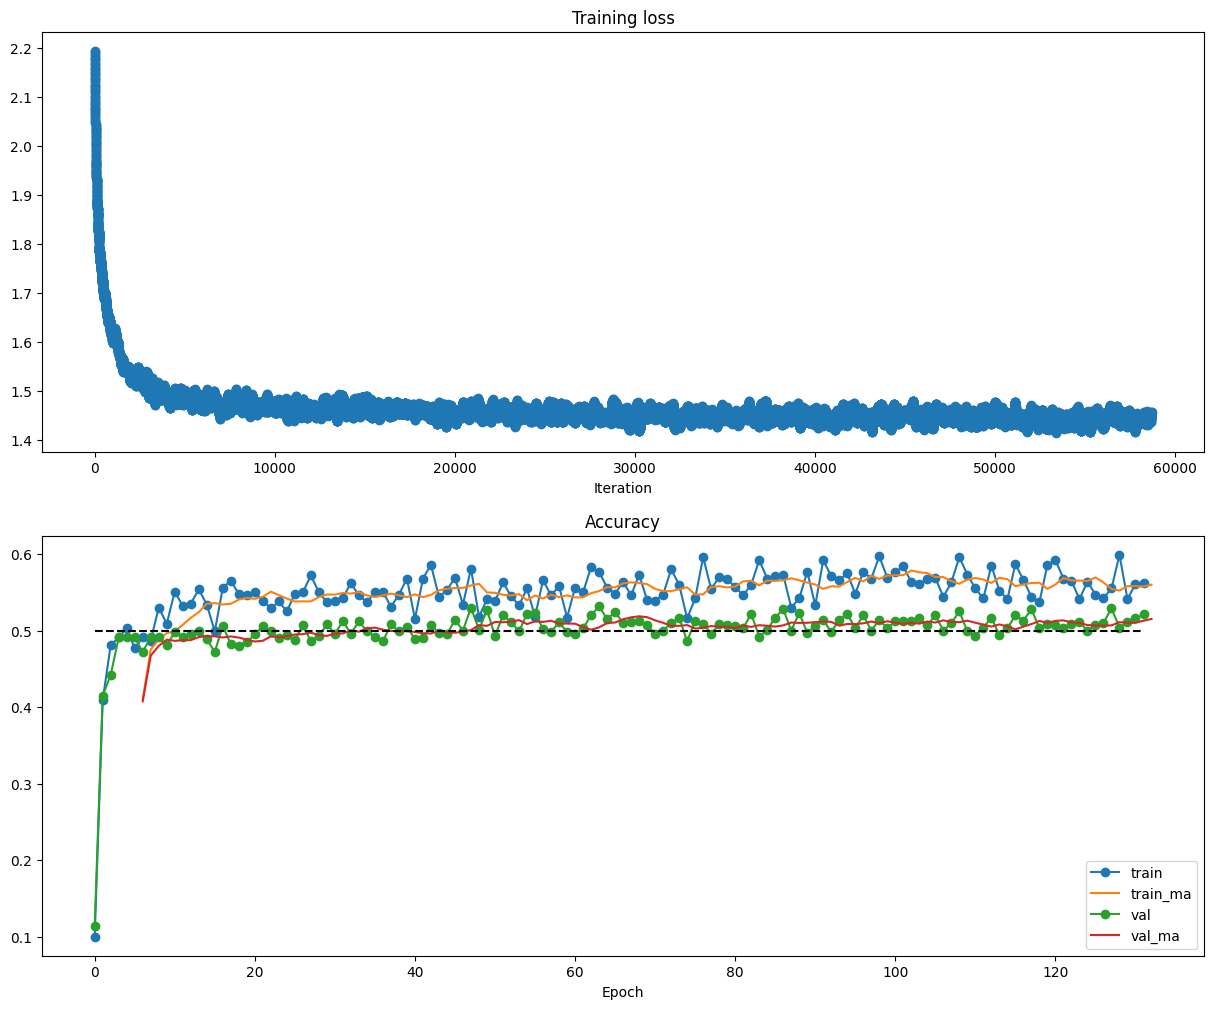

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(moving_average(solvers_reg[0.7].loss_history, 100), 'o')
plt.xlabel('Iteration')
MA = 6
LEN = len(solvers_reg[0.7].val_acc_history)
X_MA = np.linspace(MA, LEN, LEN-MA+1)


plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solvers_reg[0.7].train_acc_history, '-o', label='train')
plt.plot(X_MA, moving_average(solvers_reg[0.7].train_acc_history, MA), label='train_ma')
plt.plot(solvers_reg[0.7].val_acc_history, '-o', label='val')
plt.plot(X_MA, moving_average(solvers_reg[0.7].val_acc_history, MA), label='val_ma')
plt.plot([0.5] * len(solvers_reg[0.7].val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

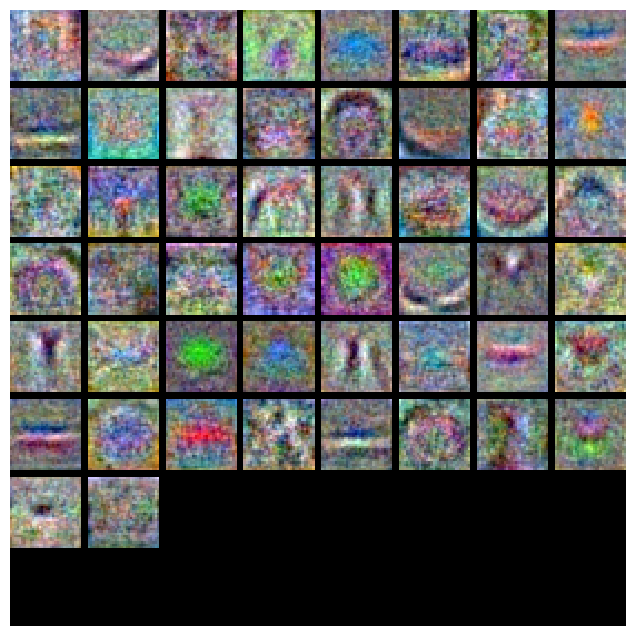

In [ ]:
show_net_weights(solvers_reg[0.7].model)

In [ ]:
LR = 2e-4
reg = 0
model_no_reg = TwoLayerNet(input_size, hidden_size, num_classes, reg=reg)
solver_no_reg = Solver(model_no_reg,
                data,
                optim_config={
                      'learning_rate': LR,
                    },
                num_epochs=30,
                print_every=200)
solver_no_reg.train()

(Iteration 1 / 14700) loss: 2.302060
(Epoch 0 / 30) train acc: 0.108000; val_acc: 0.094000
(Iteration 201 / 14700) loss: 2.030501
(Iteration 401 / 14700) loss: 1.855950
(Epoch 1 / 30) train acc: 0.387000; val_acc: 0.364000
(Iteration 601 / 14700) loss: 1.799059
(Iteration 801 / 14700) loss: 1.764684
(Epoch 2 / 30) train acc: 0.423000; val_acc: 0.409000
(Iteration 1001 / 14700) loss: 1.644087
(Iteration 1201 / 14700) loss: 1.684503
(Iteration 1401 / 14700) loss: 1.742937
(Epoch 3 / 30) train acc: 0.471000; val_acc: 0.434000
(Iteration 1601 / 14700) loss: 1.568736
(Iteration 1801 / 14700) loss: 1.549865
(Epoch 4 / 30) train acc: 0.450000; val_acc: 0.442000
(Iteration 2001 / 14700) loss: 1.550454
(Iteration 2201 / 14700) loss: 1.314686
(Iteration 2401 / 14700) loss: 1.608635
(Epoch 5 / 30) train acc: 0.475000; val_acc: 0.451000
(Iteration 2601 / 14700) loss: 1.383560
(Iteration 2801 / 14700) loss: 1.381683
(Epoch 6 / 30) train acc: 0.528000; val_acc: 0.472000
(Iteration 3001 / 14700) loss

In [ ]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

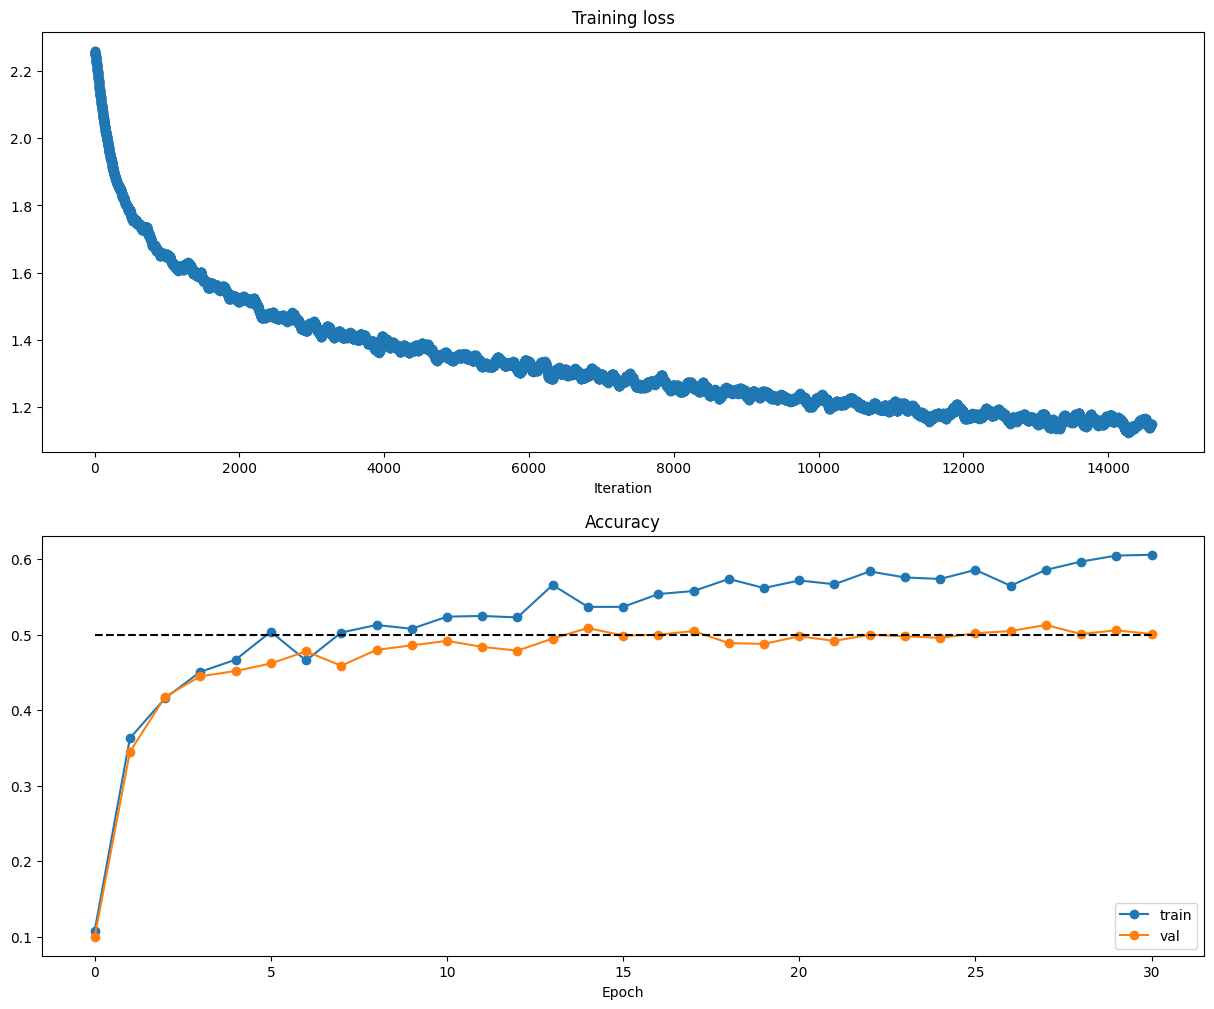

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(moving_average(solver_no_reg.loss_history, 100), 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver_no_reg.train_acc_history, '-o', label='train')
plt.plot(solver_no_reg.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver_no_reg.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [ ]:
LR = 2e-4
reg = 0.7
model_reg_best_lr = TwoLayerNet(input_size, hidden_size, num_classes, reg=reg)
solver_reg_best_lr = Solver(model_reg_best_lr,
                data,
                optim_config={
                      'learning_rate': LR,
                    },
                num_epochs=30,
                print_every=200)
solver_reg_best_lr.train()

(Iteration 1 / 14700) loss: 2.356311
(Epoch 0 / 30) train acc: 0.110000; val_acc: 0.118000
(Iteration 201 / 14700) loss: 2.085325
(Iteration 401 / 14700) loss: 1.774447
(Epoch 1 / 30) train acc: 0.364000; val_acc: 0.351000
(Iteration 601 / 14700) loss: 1.846918
(Iteration 801 / 14700) loss: 1.670665
(Epoch 2 / 30) train acc: 0.410000; val_acc: 0.413000
(Iteration 1001 / 14700) loss: 1.734743
(Iteration 1201 / 14700) loss: 1.783528
(Iteration 1401 / 14700) loss: 1.699421
(Epoch 3 / 30) train acc: 0.427000; val_acc: 0.429000
(Iteration 1601 / 14700) loss: 1.710071
(Iteration 1801 / 14700) loss: 1.756557
(Epoch 4 / 30) train acc: 0.459000; val_acc: 0.453000
(Iteration 2001 / 14700) loss: 1.732861
(Iteration 2201 / 14700) loss: 1.615326
(Iteration 2401 / 14700) loss: 1.651438
(Epoch 5 / 30) train acc: 0.453000; val_acc: 0.461000
(Iteration 2601 / 14700) loss: 1.664858
(Iteration 2801 / 14700) loss: 1.603118
(Epoch 6 / 30) train acc: 0.495000; val_acc: 0.468000
(Iteration 3001 / 14700) loss

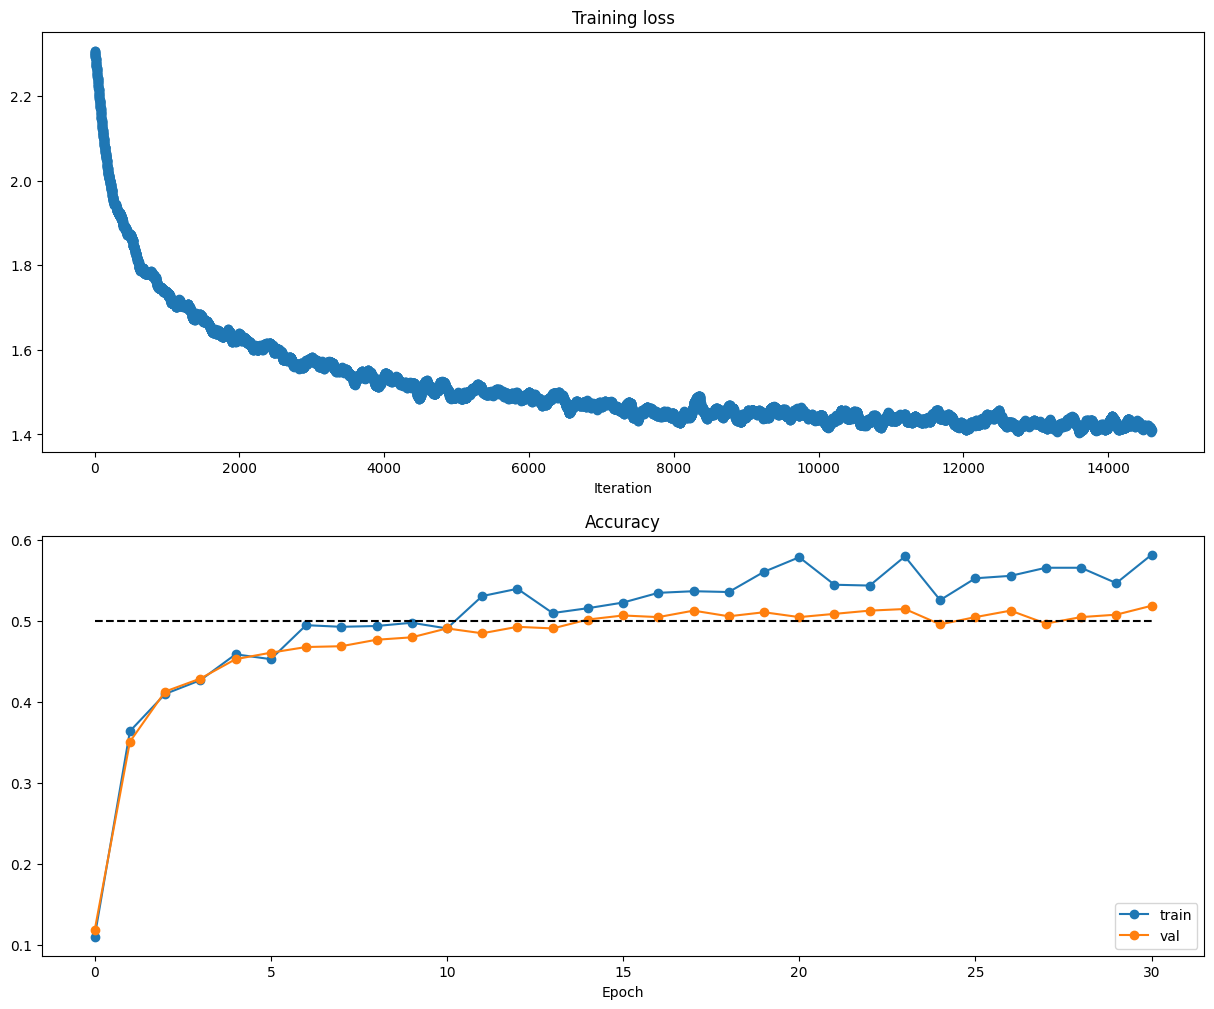

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(moving_average(solver_reg_best_lr.loss_history, 100), 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver_reg_best_lr.train_acc_history, '-o', label='train')
plt.plot(solver_reg_best_lr.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver_reg_best_lr.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

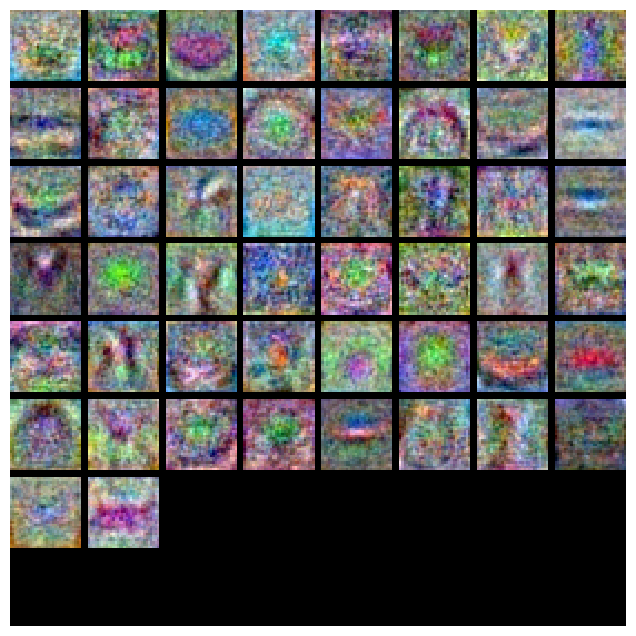

In [ ]:
show_net_weights(solver_reg_best_lr.model)

In [ ]:
learning_rates = [2e-4, 5e-4]
hidden_layers = [100, 150]
solvers_lr_hidden = dict()
for lr in learning_rates:
  print('Learning Rate: ' + str(lr))
  solvers_lr_hidden[lr] = dict()
  for hidden in hidden_layers:
    print('Hidden Size: ' + str(hidden))
    model = TwoLayerNet(input_size, hidden, num_classes)
    solvers_lr_hidden[lr][hidden] = Solver(model,
                data,
                optim_config={
                      'learning_rate': lr,
                    },
                print_every=200)
    solvers_lr_hidden[lr][hidden].train()

Learning Rate: 0.0002
Hidden Size: 100
(Iteration 1 / 4900) loss: 2.304431
(Epoch 0 / 10) train acc: 0.103000; val_acc: 0.084000
(Iteration 201 / 4900) loss: 1.937198
(Iteration 401 / 4900) loss: 2.015278
(Epoch 1 / 10) train acc: 0.343000; val_acc: 0.389000
(Iteration 601 / 4900) loss: 1.629773
(Iteration 801 / 4900) loss: 1.697179
(Epoch 2 / 10) train acc: 0.397000; val_acc: 0.434000
(Iteration 1001 / 4900) loss: 1.655271
(Iteration 1201 / 4900) loss: 1.574003
(Iteration 1401 / 4900) loss: 1.575395
(Epoch 3 / 10) train acc: 0.470000; val_acc: 0.459000
(Iteration 1601 / 4900) loss: 1.526620
(Iteration 1801 / 4900) loss: 1.547390
(Epoch 4 / 10) train acc: 0.459000; val_acc: 0.450000
(Iteration 2001 / 4900) loss: 1.454096
(Iteration 2201 / 4900) loss: 1.208783
(Iteration 2401 / 4900) loss: 1.428445
(Epoch 5 / 10) train acc: 0.494000; val_acc: 0.467000
(Iteration 2601 / 4900) loss: 1.453056
(Iteration 2801 / 4900) loss: 1.574345
(Epoch 6 / 10) train acc: 0.500000; val_acc: 0.484000
(Iter

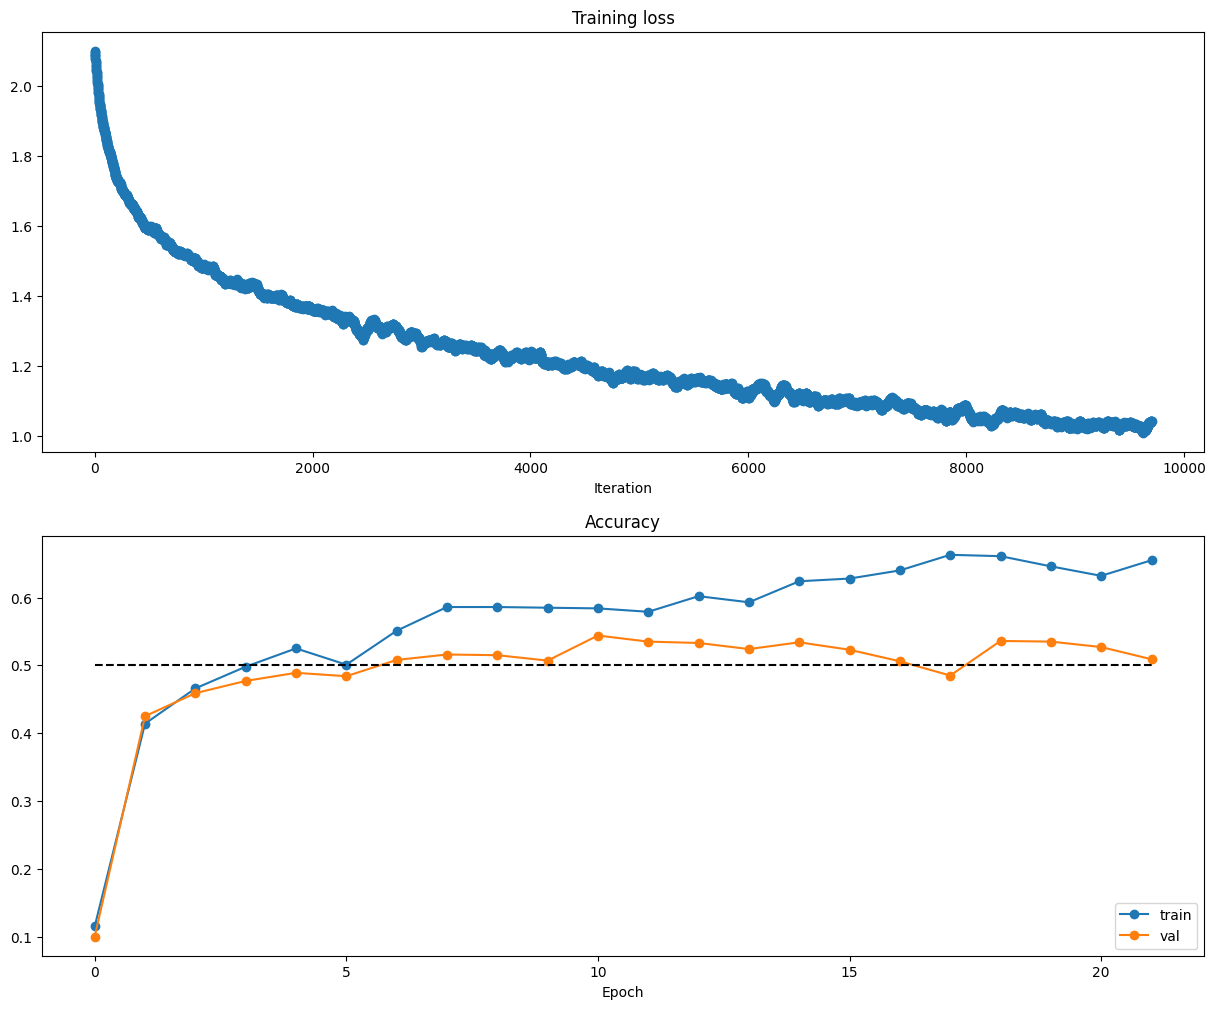

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(moving_average(model_best.loss_history, 100), 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(model_best.train_acc_history, '-o', label='train')
plt.plot(model_best.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(model_best.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

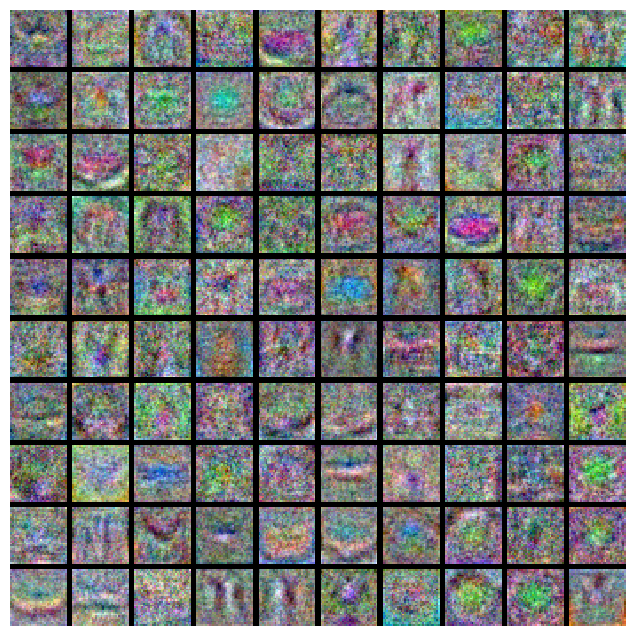

In [ ]:
show_net_weights(solvers_lr_hidden[5e-4][100].model)

In [ ]:
model_best = solvers_lr_hidden[5e-4][100]
model_best.train()

(Iteration 1 / 4900) loss: 1.316327
(Epoch 10 / 10) train acc: 0.579000; val_acc: 0.535000
(Iteration 201 / 4900) loss: 1.034030
(Iteration 401 / 4900) loss: 1.220370
(Epoch 11 / 10) train acc: 0.602000; val_acc: 0.533000
(Iteration 601 / 4900) loss: 1.169043
(Iteration 801 / 4900) loss: 1.191628
(Epoch 12 / 10) train acc: 0.593000; val_acc: 0.524000
(Iteration 1001 / 4900) loss: 1.058093
(Iteration 1201 / 4900) loss: 1.060554
(Iteration 1401 / 4900) loss: 1.067493
(Epoch 13 / 10) train acc: 0.624000; val_acc: 0.534000
(Iteration 1601 / 4900) loss: 1.216610
(Iteration 1801 / 4900) loss: 1.033784
(Epoch 14 / 10) train acc: 0.628000; val_acc: 0.523000
(Iteration 2001 / 4900) loss: 1.050009
(Iteration 2201 / 4900) loss: 1.025149
(Iteration 2401 / 4900) loss: 0.974172
(Epoch 15 / 10) train acc: 0.640000; val_acc: 0.506000
(Iteration 2601 / 4900) loss: 1.201754
(Iteration 2801 / 4900) loss: 1.187126
(Epoch 16 / 10) train acc: 0.663000; val_acc: 0.485000
(Iteration 3001 / 4900) loss: 1.02834

In [ ]:
LR = 5e-4
hidden = 100
regs = [0.5, 0.7, 0.9]
epoch = 20
solvers_lr_hidden_reg = dict()
for reg in regs:
    model = TwoLayerNet(input_size, hidden, num_classes, reg=reg)
    solvers_lr_hidden_reg[reg] = Solver(model,
                data,
                optim_config={
                      'learning_rate': LR,
                    },
                num_epochs=epoch,
                print_every=200)
    solvers_lr_hidden_reg[reg].train()

(Iteration 1 / 9800) loss: 2.376910
(Epoch 0 / 20) train acc: 0.134000; val_acc: 0.162000
(Iteration 201 / 9800) loss: 1.894198
(Iteration 401 / 9800) loss: 1.694763
(Epoch 1 / 20) train acc: 0.433000; val_acc: 0.421000
(Iteration 601 / 9800) loss: 1.623063
(Iteration 801 / 9800) loss: 1.569846
(Epoch 2 / 20) train acc: 0.493000; val_acc: 0.460000
(Iteration 1001 / 9800) loss: 1.450807
(Iteration 1201 / 9800) loss: 1.662271
(Iteration 1401 / 9800) loss: 1.454482
(Epoch 3 / 20) train acc: 0.503000; val_acc: 0.481000
(Iteration 1601 / 9800) loss: 1.414696
(Iteration 1801 / 9800) loss: 1.456818
(Epoch 4 / 20) train acc: 0.512000; val_acc: 0.491000
(Iteration 2001 / 9800) loss: 1.512082
(Iteration 2201 / 9800) loss: 1.575946
(Iteration 2401 / 9800) loss: 1.444489
(Epoch 5 / 20) train acc: 0.505000; val_acc: 0.470000
(Iteration 2601 / 9800) loss: 1.533181
(Iteration 2801 / 9800) loss: 1.555326
(Epoch 6 / 20) train acc: 0.541000; val_acc: 0.501000
(Iteration 3001 / 9800) loss: 1.327777
(Iter

In [ ]:
LR = 5e-4
hidden = 100
reg = 0.7
epoch = 20
batch_sizes = [32, 64, 150, 200]
solvers_lr_hidden_reg_batch = dict()
for batch_size in batch_sizes:
    print('Batch Size: ' + str(batch_size))
    model = TwoLayerNet(input_size, hidden, num_classes, reg=reg)
    solvers_lr_hidden_reg_batch[batch_size] = Solver(model,
                data,
                optim_config={
                      'learning_rate': LR,
                    },
                num_epochs=epoch,
                batch_size=batch_size,
                print_every=200)
    solvers_lr_hidden_reg_batch[batch_size].train()

Batch Size: 32
(Iteration 1 / 30620) loss: 2.402158
(Epoch 0 / 20) train acc: 0.144000; val_acc: 0.135000
(Iteration 201 / 30620) loss: 2.147252
(Iteration 401 / 30620) loss: 1.677687
(Iteration 601 / 30620) loss: 1.873977
(Iteration 801 / 30620) loss: 1.504766
(Iteration 1001 / 30620) loss: 2.013472
(Iteration 1201 / 30620) loss: 1.710599
(Iteration 1401 / 30620) loss: 1.496506
(Epoch 1 / 20) train acc: 0.476000; val_acc: 0.451000
(Iteration 1601 / 30620) loss: 1.890906
(Iteration 1801 / 30620) loss: 1.489268
(Iteration 2001 / 30620) loss: 1.899654
(Iteration 2201 / 30620) loss: 1.572133
(Iteration 2401 / 30620) loss: 1.814223
(Iteration 2601 / 30620) loss: 1.512443
(Iteration 2801 / 30620) loss: 1.410921
(Iteration 3001 / 30620) loss: 1.761332
(Epoch 2 / 20) train acc: 0.450000; val_acc: 0.470000
(Iteration 3201 / 30620) loss: 1.819039
(Iteration 3401 / 30620) loss: 1.948848
(Iteration 3601 / 30620) loss: 1.530352
(Iteration 3801 / 30620) loss: 1.978298
(Iteration 4001 / 30620) loss:

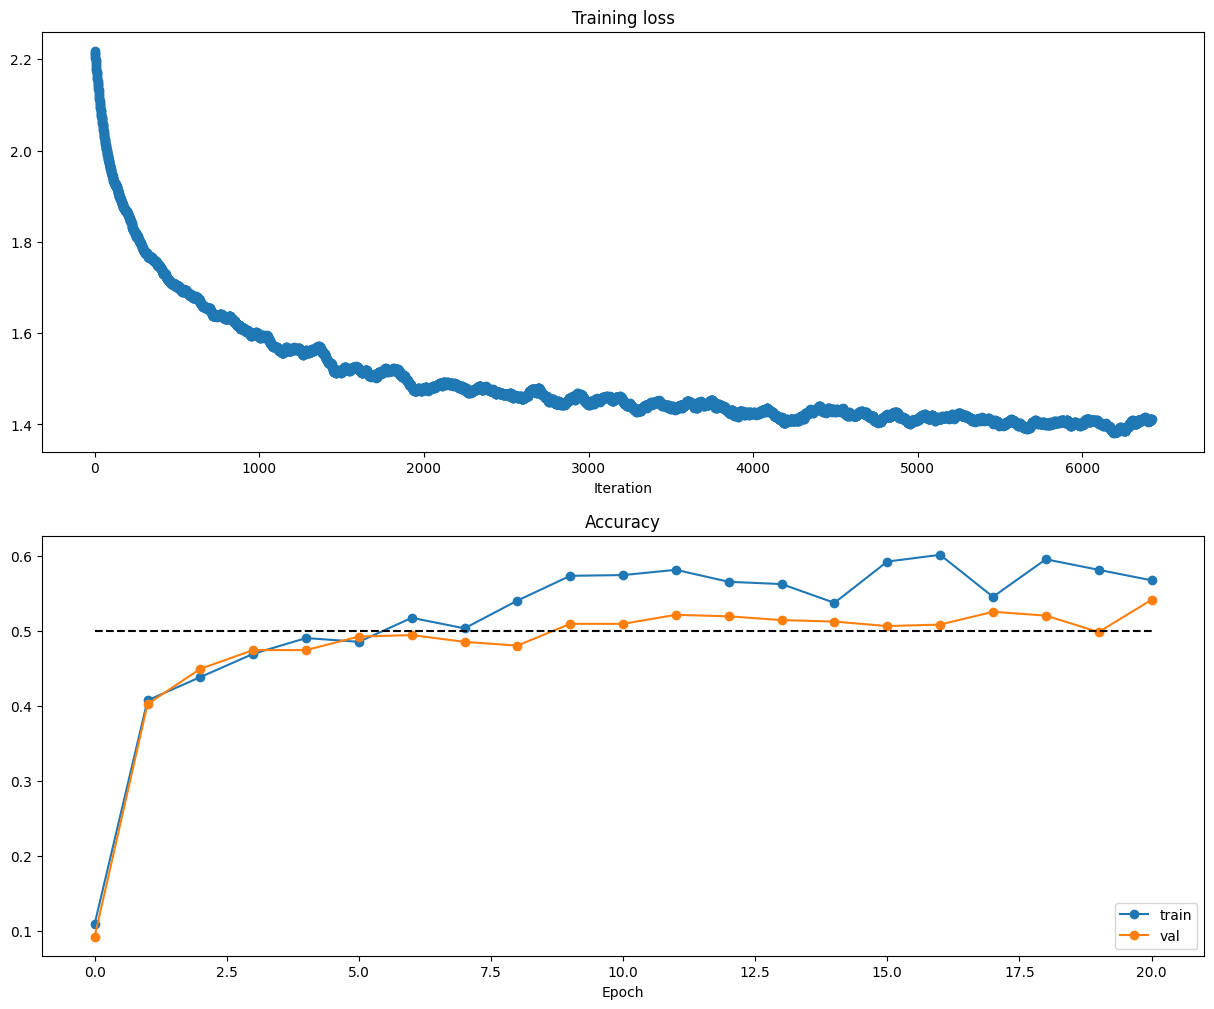

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(moving_average(solvers_lr_hidden_reg_batch[150].loss_history, 100), 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solvers_lr_hidden_reg_batch[150].train_acc_history, '-o', label='train')
plt.plot(solvers_lr_hidden_reg_batch[150].val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solvers_lr_hidden_reg_batch[150].val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

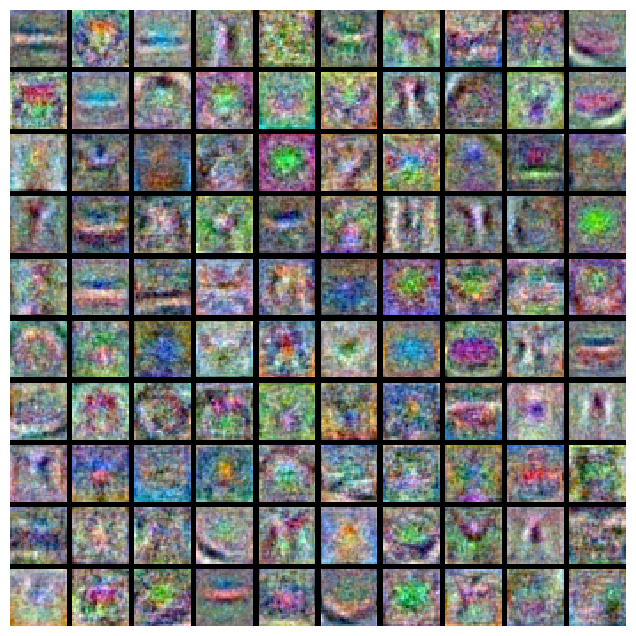

In [ ]:
show_net_weights(solvers_lr_hidden_reg_batch[150].model)


Tuning the NN:
1. LR seems to be to low as suggested above. Trying to increase it keeping the same params (reg=0, decay=1, batch_size=100, num_epochs=10) to see the results.
Results with different LR:
      1. 1e-4 : 0.467
      2. 2e-4 : 0.507 does not show the signs of overfitting. Maybe it would be beneficial to increase the number epochs to train further
      3. 5e-4 : 0.505 shows signs of overfitting, training accuracy is much higher than the validation accuracy in later epochs. Add regularization
      4. 1e-3 : 0.473

2. Trying LR 5e-4 with different reg strengths: 0.1, 0.3, 0.5, 0.7.
At some point all but the model with reg=0.7 started to overfit. Maybe it is worthy to try more epochs on this one since the val accuracy was still growing.
After trying 50 epochs I have noticed slow improvement in the accuracy. At first it seemed it oscillated near 0.5 however later on it rarely dropped below 0.5 hitting even 0.53. The last accuracy is   **0.522**
Trying some more epochs to see if it further improves.
After 70 more epochs (120 in total) the accuracy of **0.521** has been achieved. It did not seem to improve much throughout the training process

3. Increasing the number of epochs to 30 for LR 2e-4:
Training loss has been decreasing and training accuracy was increasing while validation accuracy increased insignificantly. This is a sign of overfitting. I will repeat the same with reg = 0.7. Accuracy of **0.519** has been achieved.

4. Trying to change number of hidden layers - 100 and 150 with LR 2e-4 and 5e-4.
Number of epochs - 10
regularization - 0

hidden layers, learning rate:
  - 2e-4, 100    -> 0.493
  - 2e-4, 150    -> 0.506
  - 5e-4, 100    -> 0.544
  - 5e-4, 150    -> 0.517

The best results are achieved with 100 and 150 hidden layer size and LR of 5e-4.
Very good results for lr 5e-4 and hidden size 100. Further training of the same model showed signs of overfitting. Trying the same parameters with regularizations [0.5, 0.7, 0.9] and 20 epochs.

      LR 5e-5
      hidden 100
      epochs 20

      reg 0.5 -> 0.516
      reg 0.7 -> 0.527
      reg 0.9 -> 0.517


Very consistent results accross all the combinations. That seems to be a good result and I will do another hp search across batch-size parameter values. I am choosing


```
  LR 5e-5
  hidden 100
  epochs 20
  reg 0.7
```


  (instead of reg 0 where the accuracy hit 0.544 which seems a lucky coinsidence rather than consistent result)

Trying batch-sizes [32, 64, 150, 200]

    32 -> 0.468
    64 -> 0.510
    100 -> 0.527
    150 -> 0.541
    200 -> 0.515

In [ ]:
best_model = solvers_lr_hidden_reg_batch[150].model

# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [ ]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.541


In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.531


## Inline Question 2:

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$
3. Increase the regularization strength.


$\color{blue}{\textit Your Explanation:}$

Testing accuracy might be lower than validation accuracy due to overfitting. Therefore we can try to prevent it by increasing regularization.
It might be that some classes are underrepresented in the training set and therefore the model does not train well to recognize those classes. Increasing the size of the dataset could help if we ensure all the classes are well represented in it. It will not necessarily help in all the cases.